In [4]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [7]:
!ls

datalab  drive


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [164]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [89]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [90]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [91]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [92]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [94]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [207]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)
X_train_flip = list()

In [209]:
train.shape

(28709, 1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)

  X_train_flip.append(data_augmentation(t3))
  return t3

In [0]:
def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)
  return t3

In [0]:
X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_test = np.apply_along_axis(reform_data, 1, test)
X_validation = np.apply_along_axis(reform_data, 1, validation)

In [214]:
np.array(X_train_flip).shape

(28709, 48, 48, 1)

In [215]:
X_train = np.array(list(X_train_1) + X_train_flip)
print(X_train.shape)

(57418, 48, 48, 1)


In [216]:
print(X_train.shape, X_test.shape, X_validation.shape)

(57418, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


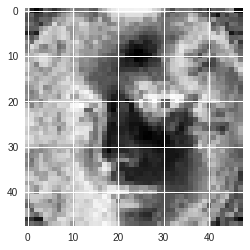

In [217]:
# Sample image
plt.imshow(X_train[0].reshape(48,48))

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_validation = X_validation/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [220]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [222]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [224]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [226]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [230]:
print(X_validation.shape, Y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation

## CNN Models
Taking 3 - 4 models for ensemble voting

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 1)

In [0]:
def Model1(input_shape=(48,48,1)):
  model = Sequential()
  
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [235]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_35 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_36 (Batc (None, 23, 23, 128)       512       
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/100
43840/57418 [=====================>........] - ETA: 27s - loss: 1.9514 - acc: 0.2219

57418/57418 [==============================] - 119s 2ms/step - loss: 1.9219 - acc: 0.2280 - val_loss: 1.8148 - val_acc: 0.2494

Epoch 00001: val_loss improved from inf to 1.81484, saving model to /drive
Epoch 2/100
17408/57418 [========>.....................] - ETA: 1:19 - loss: 1.8148 - acc: 0.2548

57418/57418 [==============================] - 117s 2ms/step - loss: 1.7975 - acc: 0.2642 - val_loss: 1.7484 - val_acc: 0.2990

Epoch 00002: val_loss improved from 1.81484 to 1.74841, saving model to /drive
Epoch 3/100
 9792/57418 [====>.........................] - ETA: 1:35 - loss: 1.6984 - acc: 0.3091

57418/57418 [==============================] - 117s 2ms/step - loss: 1.6055 - acc: 0.3644 - val_loss: 1.5635 - val_acc: 0.3862

Epoch 00003: val_loss improved from 1.74841 to 1.56349, saving model to /drive
Epoch 4/100
 7744/57418 [===>..........................] - ETA: 1:39 - loss: 1.5161 - acc: 0.4132

57418/57418 [==============================] - 117s 2ms/step - loss: 1.4612 - acc: 0.4345 - val_loss: 1.3575 - val_acc: 0.4703

Epoch 00004: val_loss improved from 1.56349 to 1.35748, saving model to /drive
Epoch 5/100
 7168/57418 [==>...........................] - ETA: 1:39 - loss: 1.3990 - acc: 0.4715

57418/57418 [==============================] - 117s 2ms/step - loss: 1.3772 - acc: 0.4776 - val_loss: 1.2935 - val_acc: 0.5068

Epoch 00005: val_loss improved from 1.35748 to 1.29351, saving model to /drive
Epoch 6/100
 6976/57418 [==>...........................] - ETA: 1:40 - loss: 1.3332 - acc: 0.4964

33664/57418 [================>.............] - ETA: 47s - loss: 1.3262 - acc: 0.5059

In [0]:
model1.save_weights("drive/face_expr.h5")